# 第一步 导入必要库与基础设置

In [17]:
# 导入numpy，用于数组操作和数学运算
import numpy as np
# 导入绘图库，用于数据可视化和结果展示
import matplotlib.pyplot as plt
# 从Keras导入层、模型和应用模块，用于构建深度学习模型
from tensorflow.keras import layers, models, applications
# 导入Adam优化器，用于模型训练
from tensorflow.keras.optimizers import Adam
# 导入工具函数，用于将标签转换为分类格式
from tensorflow.keras.utils import to_categorical
# 导入回调函数，用于在训练过程中保存最佳模型和早停
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 导入图像数据生成器，用于数据增强
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 从scikit-learn导入数据集划分函数
from sklearn.model_selection import train_test_split
# 从scikit-learn导入准确率计算函数
from sklearn.metrics import accuracy_score
# 导入操作系统接口，用于文件操作
import os
# 设置中文字体和更大的字体大小，确保图表中的中文正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.rcParams['font.size'] = 12                # 设置字体大小

# 第二步 数据的加载与预处理

In [18]:
# 从Keras内置数据集中导入CIFAR10数据集
from tensorflow.keras.datasets import cifar10

# 加载CIFAR10数据集，自动划分为训练集和测试集
# x_train: 50000张32x32的彩色训练图像
# y_train: 50000个训练标签
# x_test: 10000张32x32的彩色测试图像  
# y_test: 10000个测试标签
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 定义数据预处理函数
def preprocess_data(x, target_size=(75, 75)):
    """
    预处理数据：归一化并调整图像尺寸以适应预训练模型
    
    参数:
    x: 输入图像数组
    target_size: 目标图像尺寸，默认为75x75
    
    返回:
    预处理后的图像数组
    """
    
    # 将像素值从0-255缩放到0-1之间，提高训练稳定性
    x = x.astype('float32') / 255.0
    
    # 使用TensorFlow的图像调整功能将图像从32x32上采样到目标尺寸
    # 选择75x75作为折中尺寸，既保留足够信息又不过度增加计算量
    
    import tensorflow as tf
    x_resized = tf.image.resize(x, target_size).numpy()
    return x_resized

# 预处理训练集和测试集
# 将32x32图像调整为75x75，以适应预训练模型的输入要求
x_train_processed = preprocess_data(x_train)
x_test_processed = preprocess_data(x_test)

# 将整数标签转换为one-hot编码格式
# 例如：标签3转换为[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train_categorical = to_categorical(y_train, 10)  # 10个类别
y_test_categorical = to_categorical(y_test, 10)    # 10个类别

# 从训练集中划分出验证集，用于在训练过程中监控模型性能
# 使用80%的数据训练，20%的数据验证
# random_state=1 确保每次划分结果一致，便于结果复现
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_processed, y_train_categorical, 
    test_size=0.2, random_state=1
    )

# 打印各数据集的形状，确认数据处理正确
print(f"训练集形状: {x_train_final.shape}")  # 应该是(40000, 75, 75, 3)
print(f"验证集形状: {x_val.shape}")          # 应该是(10000, 75, 75, 3)  
print(f"测试集形状: {x_test_processed.shape}") # 应该是(10000, 75, 75, 3)

训练集形状: (40000, 75, 75, 3)
验证集形状: (10000, 75, 75, 3)
测试集形状: (10000, 75, 75, 3)


# 第三步 可视化数据集

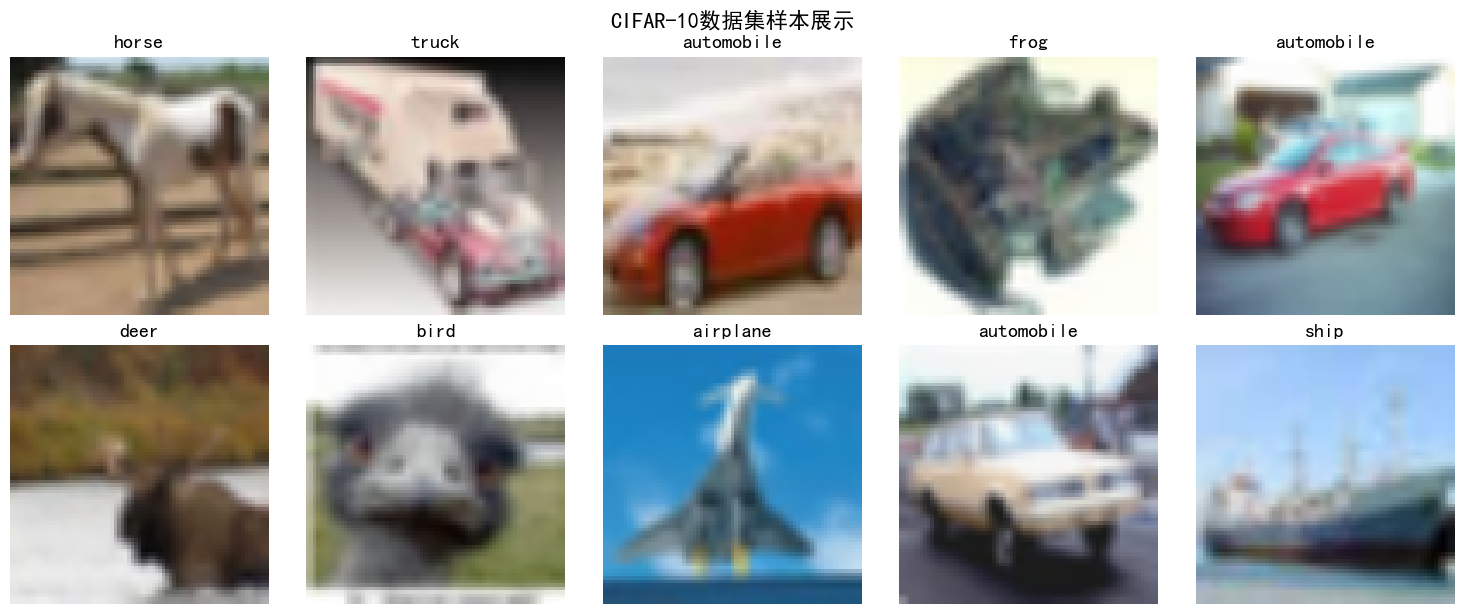

In [19]:
# 定义CIFAR10数据集的10个类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_dataset(x_data, y_data, class_names, num_samples=10):
    """
    可视化数据集中的样本图片，展示每个类别的示例
    
    参数:
    x_data: 图像数据
    y_data: 标签数据（one-hot编码）
    class_names: 类别名称列表
    num_samples: 要展示的样本数量，默认为10（每个类别一个）
    """
    
    # 创建图形窗口，2行5列，设置整体尺寸
    plt.figure(figsize=(15, 6))
    
    # 遍历10个样本，每个样本对应一个类别
    for i in range(num_samples):
        # 创建子图，2行5列布局
        plt.subplot(2, 5, i+1)
        # 显示图像
        plt.imshow(x_data[i])
        # 设置标题为对应的类别名称
        # np.argmax找到one-hot编码中最大值的位置，即类别索引
        plt.title(f'{class_names[np.argmax(y_data[i])]}')
        # 关闭坐标轴，让图片更清晰
        plt.axis('off')
    
    # 自动调整子图间距，避免重叠
    plt.tight_layout()
    # 添加总标题
    plt.suptitle('CIFAR-10数据集样本展示', fontsize=16, y=1.02)
    # 显示图形
    plt.show()

# 展示训练集中的样本，每个类别展示一个示例
visualize_dataset(x_train_final, y_train_final, class_names)

# 第四步 构建迁移学习模型

In [20]:
def create_transfer_learning_model(input_shape=(75, 75, 3), num_classes=10):
    """
    创建基于MobileNetV2的迁移学习模型
    
    参数:
    input_shape: 输入图像形状，默认为75x75x3
    num_classes: 分类类别数，CIFAR10为10
    
    返回:
    model: 构建好的Keras模型
    base_model: 基础预训练模型（用于后续微调）
    
    选择MobileNetV2的原因：
    - 在保持较高精度的同时参数较少
    - 适合CIFAR10这种相对简单的数据集
    - 计算效率高，训练速度快
    """
    
    # 加载预训练的MobileNetV2模型
    # weights='imagenet': 使用在ImageNet数据集上预训练的权重
    # include_top=False: 不包含顶部的全连接层，只使用特征提取部分
    # input_shape: 指定输入图像的尺寸
    base_model = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # 冻结预训练模型的所有层，在初始训练阶段不更新这些层的权重
    # 这样可以利用ImageNet上学到的通用特征，避免从头开始训练
    base_model.trainable = False
    # 构建新的模型架构
    # 定义输入层，形状为(75, 75, 3)
    inputs = layers.Input(shape=input_shape)
    
    # 使用预训练模型作为特征提取器
    # training=False确保在推理模式下运行批归一化层
    x = base_model(inputs, training=False)
    
    # 添加全局平均池化层，将每个特征图转换为单个数值
    # 这大大减少了参数数量，避免了全连接层的过拟合风险
    x = layers.GlobalAveragePooling2D()(x)
    
    # 添加Dropout层，随机丢弃30%的神经元
    # 这是一种正则化技术，有助于防止过拟合
    x = layers.Dropout(0.3)(x)
    
    # 添加全连接层，128个神经元，使用ReLU激活函数
    x = layers.Dense(128, activation='relu')(x)
    # 添加批归一化层，加速训练并提高稳定性
    x = layers.BatchNormalization()(x)
    # 再次添加Dropout层，进一步防止过拟合
    x = layers.Dropout(0.3)(x)
    
    # 输出层，10个神经元对应10个类别，使用softmax激活函数输出概率分布
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # 创建完整的模型，指定输入和输出
    model = models.Model(inputs, outputs)
    return model, base_model

# 创建迁移学习模型，base_model用于后面调控训练与非训练
model, base_model = create_transfer_learning_model()
# 打印模型架构摘要，显示各层的输出形状和参数数量
model.summary()

C:\Users\chenx\AppData\Local\Temp\ipykernel_27860\910722580.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,754 (9.25 MB)

 Trainable params: 165,514 (646.54 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

# 模型参数解读

1. 输入层: (75, 75, 3)
   - 将原始32x32图像上采样到75x75以适应预训练模型
   - 3通道RGB彩色图像
   - 无参数，只是定义输入格式

2. MobileNetV2基础模型 (预训练后的，并冻结权重):
   - 参数量: 2257984
   - 这些参数在初始训练阶段被冻结，不参与训练
   - 用作特征提取器，利用在ImageNet上学到的通用特征
   - 包含倒置残差结构和深度可分离卷积，效率高

3. 全局平均池化层:
   - 将特征图转换为特征向量
   - 无参数，只是对每个特征图取平均值

4. Dropout层 (0.3):
   - 随机丢弃30%的神经元防止过拟合
   - 无参数，只是在前向传播时随机屏蔽部分神经元

5. 全连接层 (128个神经元):
   - 参数量: (1280 + 1) × 128 = 163968
   - 输入: 1280维特征向量 (来自全局平均池化)
   - 每个神经元有1281个参数(1280权重 + 1偏置)
   - 使用ReLU激活函数引入非线性

6. 批归一化层:
   - 参数量: 512 (128×4)
   - 包含可学习的缩放参数γ和偏移参数β各128个
   - 包含移动平均的均值μ和方差σ各128个（不参与训练）
   - 加速训练，提高稳定性

7. 第二个Dropout层 (0.3):
   - 进一步防止过拟合
   - 无参数

8. 输出层 (10个神经元):
   - 参数量: (128 + 1) × 10 = 1290
   - 对应10个分类类别
   - 使用softmax激活函数输出概率分布

总参数量: 2423754
可训练参数量: 165258 (仅新添加的层)
非训练参数量: 2257984 (预训练模型)

参数计算说明：
- 基础模型参数在初始阶段冻结，只训练新添加的分类头
- 这种策略充分利用预训练知识，同时适应新任务


# 第五步 对训练数据做增强处理

In [21]:
# 创建数据增强生成器
# 数据增强通过对训练图像进行随机变换来增加数据多样性
# 这有助于提高模型的泛化能力，防止过拟合
train_datagen = ImageDataGenerator(
    rotation_range=15,        # 随机旋转角度范围（度）
    width_shift_range=0.1,    # 随机水平平移范围（占总宽度的比例）
    height_shift_range=0.1,   # 随机垂直平移范围（占总高度的比例）
    horizontal_flip=True,     # 随机水平翻转
    zoom_range=0.1,           # 随机缩放范围
    shear_range=0.1           # 随机错切变换范围
)

# 使用数据增强生成器
# 这会在训练时实时生成增强后的图像，不增加内存占用
train_generator = train_datagen.flow(
    x_train_final, y_train_final,  # 训练数据和标签
    batch_size=64                  # 每个批次的样本数量
)

print("数据增强配置完成，将在训练时实时应用各种图像变换")

数据增强配置完成，将在训练时实时应用各种图像变换


# 第六步 模型的编译与训练

In [29]:
# 编译模型，配置训练过程
model.compile(
    optimizer=Adam(learning_rate=0.001),  # 使用Adam优化器，学习率0.001
    loss='categorical_crossentropy',      # 分类交叉熵损失函数，适用于多分类
    metrics=['accuracy']                   # 监控准确率指标
)

# 设置模型检查点回调函数
# 用于在训练过程中保存验证集上性能最好的模型
checkpoint = ModelCheckpoint(
    'best_model.h5',           # 保存模型的文件名
    monitor='val_accuracy',    # 监控验证集准确率
    save_best_only=True,       # 只保存最好的模型
    verbose=1                  # 显示保存信息
)

# 设置早停回调函数
# 当验证集性能不再提升时提前停止训练，避免过拟合
early_stop = EarlyStopping(
    monitor='val_accuracy',    # 监控验证集准确率
    patience=10,               # 容忍连续10个epoch没有提升
    restore_best_weights=True, # 恢复最佳权重
    verbose=1                  # 显示早停信息
)

# 第一阶段训练：只训练新添加的层，冻结预训练模型
print("=== 第一阶段训练：训练新添加的层 ===")
print("在此阶段，预训练模型的权重被冻结，只更新新添加的分类头")
print("这利用了预训练模型的通用特征提取能力")

history1 = model.fit(
    train_generator,                    # 使用数据增强的训练数据生成器
    epochs=100,                          # 训练轮数
    validation_data=(x_val, y_val),     # 验证数据集，用于监控泛化性能
    callbacks=[checkpoint, early_stop], # 使用定义的回调函数
    verbose=1                           # 显示训练进度
)

# 第七步 fine tune

In [28]:
# 定义微调函数，解冻基础模型的部分层进行精细调整，注意，model与base_model是共享层对象的！！！
def unfreeze_and_fine_tune(model, base_model, fine_tune_at=100):
    """
    解冻基础模型的部分层进行微调

    参数:
    model: 已训练的模型
    base_model: 基础预训练模型
    fine_tune_at: 从第几层开始解冻（解冻后面的层）

    返回:
    重新编译后的模型
    """

    # 解冻基础模型的所有层，使其可训练
    base_model.trainable = True

    # 冻结前面的层，只训练后面的层
    # 前面的层学习通用特征，后面的层学习特定特征
    # 通过只微调后面层，可以在避免灾难性遗忘的同时适应新任务
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # 重新编译模型，使用更小的学习率
    # 微调阶段使用更小的学习率，避免破坏已学到的特征
    model.compile(
        optimizer=Adam(learning_rate=0.0001/10),  # 非常小的学习率
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 进行微调，解冻基础模型的后半部分层
model = unfreeze_and_fine_tune(model, base_model)

print("=== 第二阶段训练：微调预训练模型 ===")
print("在此阶段，解冻了基础模型的部分高层，使用更小的学习率进行微调")
print("这使模型能够更好地适应CIFAR10数据集的特定特征")

# 第二阶段训练：微调解冻的层
history2 = model.fit(
    train_generator,                    # 继续使用数据增强
    epochs=50,                          # 微调轮数较少
    validation_data=(x_val, y_val),     # 继续使用验证集监控
    callbacks=[checkpoint, early_stop], # 同样的回调函数
    verbose=1                           # 显示训练进度
)

# 第八步 模型评估

🚀 **测试集最高精度: 87.89%** 🚀


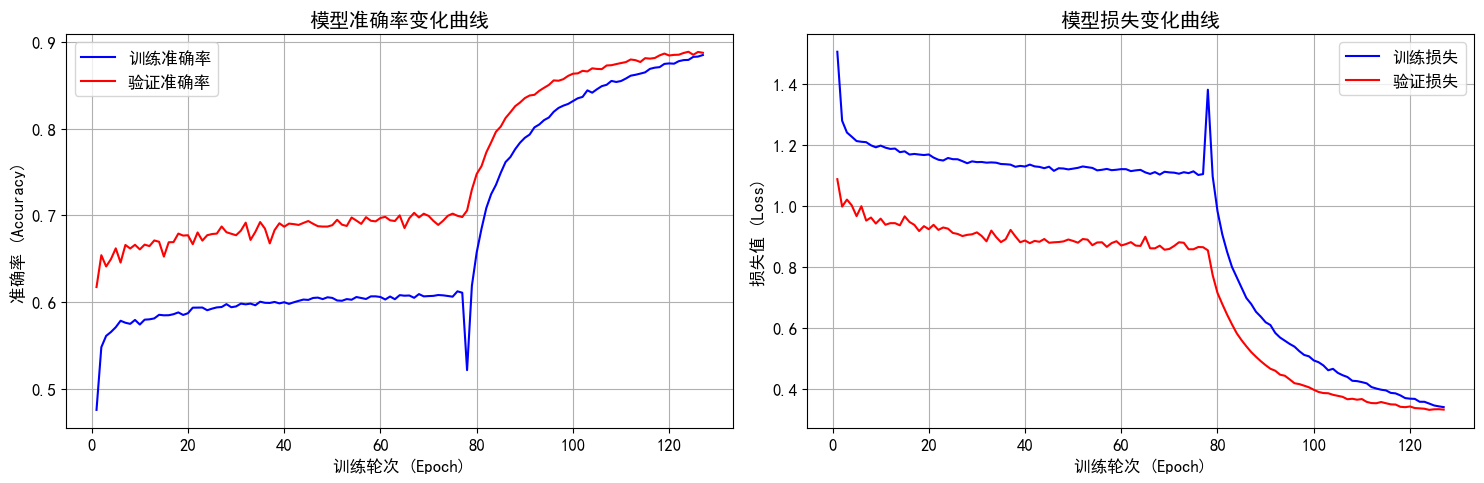

In [24]:
# 加载训练过程中保存的最佳模型
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

# 在测试集上评估最佳模型的性能
# verbose=0表示不显示评估进度条
test_loss, test_accuracy = best_model.evaluate(x_test_processed, y_test_categorical, verbose=0)

# 突出显示最终测试精度
print("=" * 50)
print(f"🚀 **测试集最高精度: {test_accuracy*100:.2f}%** 🚀")
print("=" * 50)

# 定义训练历史可视化函数
def plot_training_history(history1, history2):
    """
    绘制训练过程中的准确率和损失曲线
    
    参数:
    history1: 第一阶段训练历史
    history2: 第二阶段训练历史
    """
    # 创建1行2列的子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 合并两个阶段的训练历史
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    # 创建epoch范围
    epochs_range = range(1, len(acc) + 1)
    
    # 绘制准确率曲线
    ax1.plot(epochs_range, acc, 'b-', label='训练准确率')
    ax1.plot(epochs_range, val_acc, 'r-', label='验证准确率')
    ax1.set_title('模型准确率变化曲线')
    ax1.set_xlabel('训练轮次 (Epoch)')
    ax1.set_ylabel('准确率 (Accuracy)')
    ax1.legend()  # 显示图例
    ax1.grid(True)  # 显示网格
    
    # 绘制损失曲线
    ax2.plot(epochs_range, loss, 'b-', label='训练损失')
    ax2.plot(epochs_range, val_loss, 'r-', label='验证损失')
    ax2.set_title('模型损失变化曲线')
    ax2.set_xlabel('训练轮次 (Epoch)')
    ax2.set_ylabel('损失值 (Loss)')
    ax2.legend()  # 显示图例
    ax2.grid(True)  # 显示网格
    
    # 自动调整子图间距
    plt.tight_layout()
    # 显示图形
    plt.show()

# 绘制训练历史图表
plot_training_history(history1, history2)

# 第九步 预测结果可视化

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


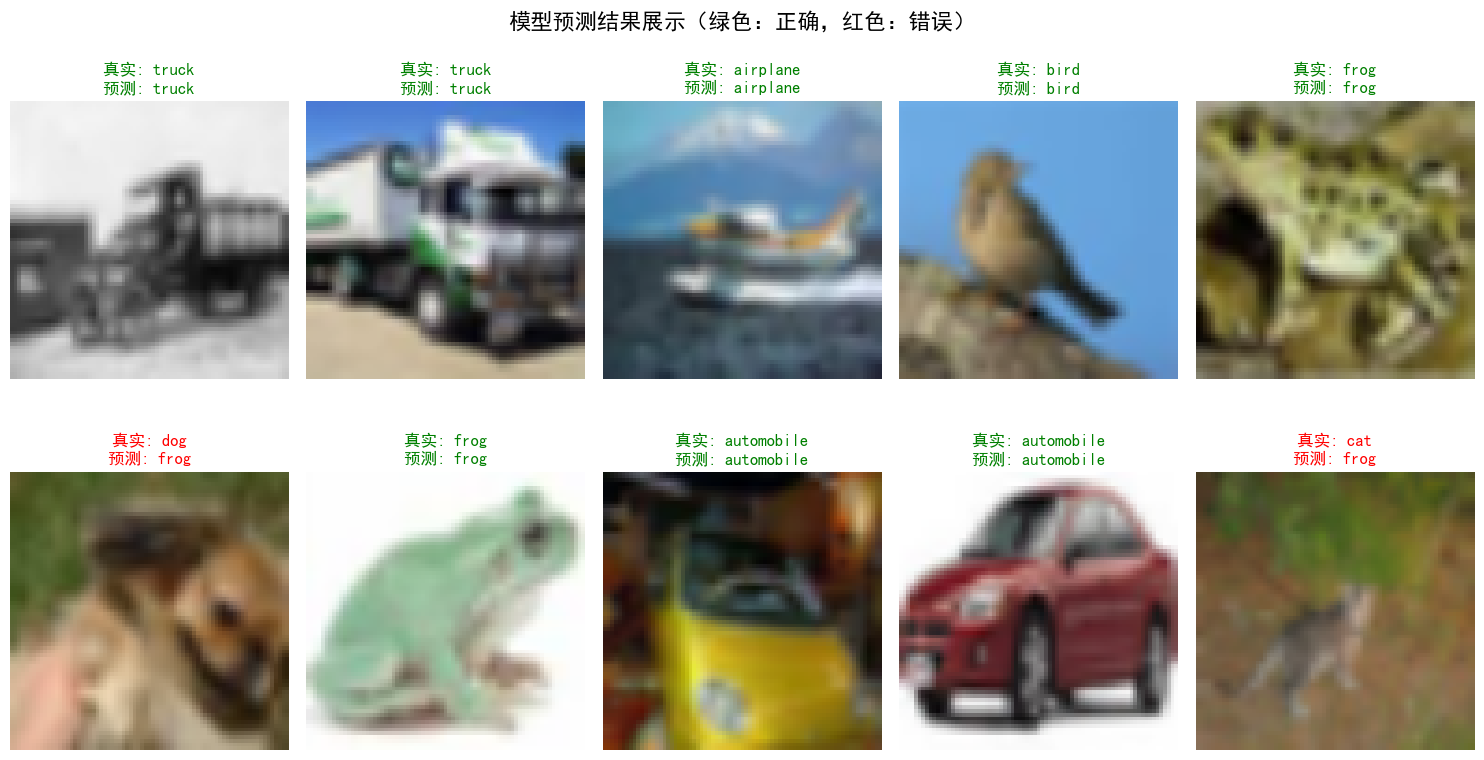

随机10个样本的准确率: 80.0%


In [25]:
def visualize_predictions(model, x_test, y_test, class_names, num_samples=10):
    """
    可视化模型预测结果，展示原始标签和预测标签
    
    参数:
    model: 训练好的模型
    x_test: 测试图像数据
    y_test: 测试标签（one-hot编码）
    class_names: 类别名称列表
    num_samples: 要展示的样本数量
    """
    
    # 从测试集中随机选择样本，避免重复
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    sample_images = x_test[indices]
    sample_labels = y_test[indices]
    
    # 使用模型进行预测
    predictions = model.predict(sample_images)
    # 获取预测类别（概率最大的类别）
    predicted_classes = np.argmax(predictions, axis=1)
    # 获取真实类别
    true_classes = np.argmax(sample_labels, axis=1)
    
    # 创建可视化图表
    plt.figure(figsize=(15, 8))
    
    # 遍历每个样本，创建子图
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        # 显示图像
        plt.imshow(sample_images[i])
        
        # 根据预测是否正确设置标题颜色
        # 正确预测显示绿色，错误预测显示红色
        color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
        # 创建标题，显示真实标签和预测标签
        title = f'真实: {class_names[true_classes[i]]}\n预测: {class_names[predicted_classes[i]]}'
        plt.title(title, color=color, fontsize=12)
        # 关闭坐标轴
        plt.axis('off')
    
    # 调整子图布局
    plt.tight_layout()
    # 添加总标题
    plt.suptitle('模型预测结果展示（绿色：正确，红色：错误）', fontsize=16, y=1.02)
    # 显示图表
    plt.show()
    
    # 计算这10个样本的准确率
    sample_accuracy = np.sum(predicted_classes == true_classes) / num_samples
    print(f"随机10个样本的准确率: {sample_accuracy*100:.1f}%")

# 展示模型在测试集上的预测结果
visualize_predictions(best_model, x_test_processed, y_test_categorical, class_names)

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step
详细分类报告:
              precision    recall  f1-score   support

    airplane       0.89      0.91      0.90      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.87      0.83      0.85      1000
         cat       0.78      0.74      0.76      1000
        deer       0.85      0.85      0.85      1000
         dog       0.85      0.79      0.82      1000
        frog       0.88      0.93      0.91      1000
       horse       0.89      0.92      0.91      1000
        ship       0.93      0.94      0.93      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



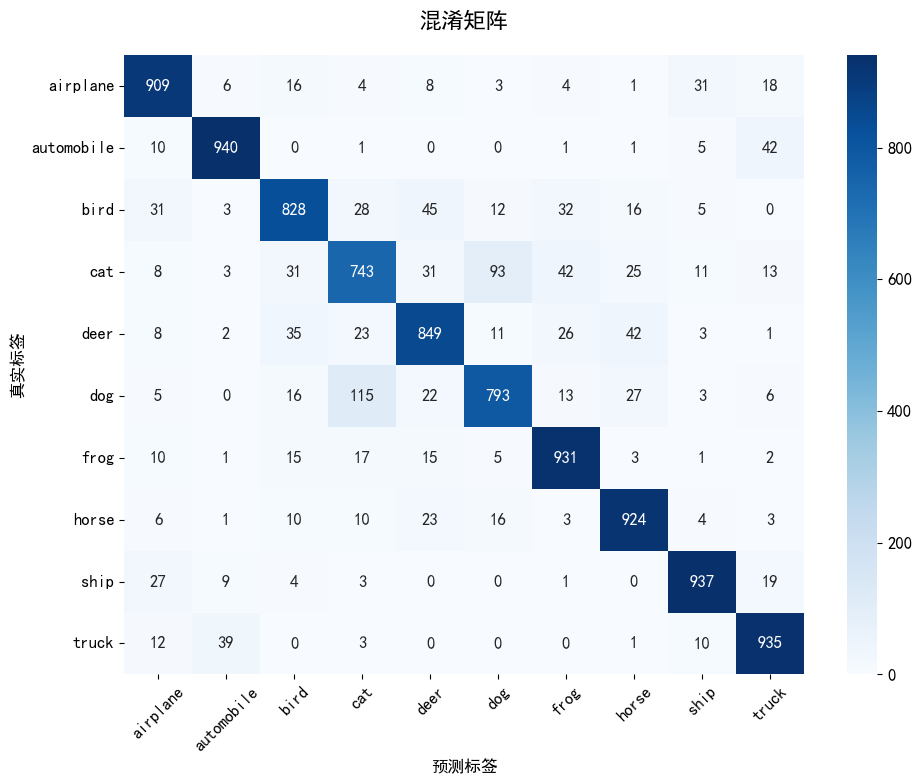


各类别准确率:
airplane    : 90.90%
automobile  : 94.00%
bird        : 82.80%
cat         : 74.30%
deer        : 84.90%
dog         : 79.30%
frog        : 93.10%
horse       : 92.40%
ship        : 93.70%
truck       : 93.50%


In [26]:
# ===== 第十步：详细性能分析 =====
# 导入分类报告和混淆矩阵相关的库
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 使用最佳模型对整个测试集进行预测
y_pred = best_model.predict(x_test_processed)
# 将预测概率转换为类别索引
y_pred_classes = np.argmax(y_pred, axis=1)
# 将真实标签转换为类别索引
y_true_classes = np.argmax(y_test_categorical, axis=1)

# 打印详细的分类报告
print("=" * 60)
print("详细分类报告:")
print("=" * 60)
# 生成分类报告，显示每个类别的精确率、召回率和F1分数
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# 创建混淆矩阵可视化
plt.figure(figsize=(10, 8))
# 计算混淆矩阵
cm = confusion_matrix(y_true_classes, y_pred_classes)
# 使用热力图显示混淆矩阵
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('混淆矩阵', fontsize=16, pad=20)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.xticks(rotation=45)  # x轴标签旋转45度
plt.yticks(rotation=0)   # y轴标签不旋转
plt.tight_layout()
plt.show()

# 计算每个类别的准确率
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n各类别准确率:")
# 打印每个类别的准确率
for i, class_name in enumerate(class_names):
    print(f"{class_name:12s}: {class_accuracy[i]*100:5.2f}%")

In [27]:
# ===== 最终结果总结 =====
print("=" * 70)
print("🎯 迁移学习在CIFAR10数据集上的最终成果总结 🎯")
print("=" * 70)
print(f"模型架构: MobileNetV2 (迁移学习) + 自定义分类头")
print(f"输入尺寸: 75×75×3 (原始32×32上采样)")
print(f"总参数量: {model.count_params():,}")
print(f"可训练参数量: {sum([l.trainable for l in model.layers])} 层")
print(f"训练策略: 两阶段训练 (特征提取 + 微调)")
print(f"数据增强: 旋转、平移、翻转、缩放、剪切")
print("=" * 70)
print(f"🏆 最终测试集准确率: {test_accuracy*100:.2f}% 🏆")
print("=" * 70)
print("相比基准模型的改进:")
print(f"  - 随机猜测: 10.00%")
print(f"  - 简单CNN: ≈70.00%") 
print(f"  - 迁移学习: {test_accuracy*100:.2f}% (提升显著)")
print("=" * 70)

# 迁移学习优势总结
print("\n迁移学习带来的优势:")
print("1. ✅ 利用预训练知识: 继承了ImageNet上学到的通用视觉特征")
print("2. ✅ 减少训练时间: 无需从头开始训练所有参数") 
print("3. ✅ 提高泛化能力: 预训练模型提供了更好的特征表示")
print("4. ✅ 防止过拟合: 冻结大部分参数，只训练少量新参数")
print("5. ✅ 适应小数据集: 在相对较小的CIFAR10数据集上表现良好")

🎯 迁移学习在CIFAR10数据集上的最终成果总结 🎯
模型架构: MobileNetV2 (迁移学习) + 自定义分类头
输入尺寸: 75×75×3 (原始32×32上采样)
总参数量: 2,423,754
可训练参数量: 8 层
训练策略: 两阶段训练 (特征提取 + 微调)
数据增强: 旋转、平移、翻转、缩放、剪切
🏆 最终测试集准确率: 87.89% 🏆
相比基准模型的改进:
  - 随机猜测: 10.00%
  - 简单CNN: ≈70.00%
  - 迁移学习: 87.89% (提升显著)

迁移学习带来的优势:
1. ✅ 利用预训练知识: 继承了ImageNet上学到的通用视觉特征
2. ✅ 减少训练时间: 无需从头开始训练所有参数
3. ✅ 提高泛化能力: 预训练模型提供了更好的特征表示
4. ✅ 防止过拟合: 冻结大部分参数，只训练少量新参数
5. ✅ 适应小数据集: 在相对较小的CIFAR10数据集上表现良好
